In [3]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model, Sequential
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from keras.preprocessing import image
import h5py

In [4]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc')>0.99):
            print("\nReached 99% accuracy so cancelling training!")
            self.model.stop_training=True

In [5]:
def transfer_learning_model(localpath1):
    #create and load pre trained model:
    pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                    include_top = False,
                                    weights = None)
    pre_trained_model.load_weights(localpath1)

    for layer in pre_trained_model.layers:
        layer.trainable = False


    last_layer = pre_trained_model.get_layer('mixed7')
    print("Last layer:", last_layer.output_shape)
    last_output = last_layer.output
    return last_output, pre_trained_model

In [6]:
def generating_data(local_path1):
    train_datagen = ImageDataGenerator(rescale = 1/255,
                                        rotation_range = 40,
                                        width_shift_range = 0.2,
                                        height_shift_range = 0.2,
                                        shear_range = 0.2,
                                        zoom_range = 0.2,
                                        horizontal_flip = True)

    validation_datagen = ImageDataGenerator(rescale = 1/255)

    train_gen = train_datagen.flow_from_directory(
        local_path1 + 'training_set/',
        target_size = (150,150),
        batch_size = 20,
        class_mode = 'binary'
        )

    validation_gen = validation_datagen.flow_from_directory(
        local_path1 + 'validation_set/',
        target_size = (150,150),
        batch_size = 20, 
        class_mode = 'binary'
        )

    return train_gen, validation_gen


In [7]:
def building_model(local_path1, last_output, pre_trained_model):
    callbacks = myCallback()

    x = layers.Flatten()(last_output)
    x = layers.Dense(1024, activation = 'relu')(x)
    #Dropouts step
    x = layers.Dense(1,activation = 'sigmoid')(x)
    model = Model(pre_trained_model.input,x)
    model.summary()
    model.compile(optimizer = RMSprop(lr=1e-04),
                    loss = 'binary_crossentropy',
                    metrics = ['acc'])
    
    train_generator, validation_generator=generating_data(local_path1)

    history = model.fit(
        train_generator, steps_per_epoch = 100,
        epochs = 10, verbose = 2,
        validation_data = validation_generator,
        validation_steps = 50,
        callbacks = [callbacks]
        )
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    #evaluate the model
    model_evaluation(acc, val_acc, loss, val_loss)
    ## save model
    model.save('final_model.h5') 
    print("model_saved!!")

    return model

In [8]:
def model_evaluation(acc, val_acc, loss, val_loss):
    epochs = range(len(acc))

    #training and validation accuracy and loss
    plt.plot(epochs,acc, 'r', "Training Accuracy")
    plt.plot(epochs,val_acc, 'b')
    plt.title("Training and validation accuracy")

    plt.plot(epochs,loss)
    plt.plot(epochs,val_loss)
    plt.title("Training and validation loss")

In [12]:
def main():
    
    local_path0 = 'data/learning/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
    local_path1 = 'data/'
    #training model
    last_output, pre_trained_model = transfer_learning_model(local_path0)
    model = building_model(local_path1, last_output, pre_trained_model)
    model = tf.keras.models.load_model('final_model.h5')



Last layer: (None, 7, 7, 768)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 74, 74, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 74, 32)   0           batch_normalization_94[0][0]     
______________________________________________________________

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Epoch 1/10
100/100 - 84s - loss: 0.3410 - acc: 0.8615 - val_loss: 0.0807 - val_acc: 0.9680
Epoch 2/10
100/100 - 85s - loss: 0.2307 - acc: 0.9125 - val_loss: 0.0812 - val_acc: 0.9670
Epoch 3/10
100/100 - 92s - loss: 0.1955 - acc: 0.9235 - val_loss: 0.1150 - val_acc: 0.9520
Epoch 4/10
100/100 - 92s - loss: 0.1805 - acc: 0.9280 - val_loss: 0.1126 - val_acc: 0.9590
Epoch 5/10
100/100 - 88s - loss: 0.2235 - acc: 0.9145 - val_loss: 0.1062 - val_acc: 0.9660
Epoch 6/10
100/100 - 88s - loss: 0.1821 - acc: 0.9295 - val_loss: 0.1241 - val_acc: 0.9590
Epoch 7/10
100/100 - 90s - loss: 0.1853 - acc: 0.9245 - val_loss: 0.1629 - val_acc: 0.9470
Epoch 8/10
100/100 - 89s - loss: 0.1904 - acc: 0.9320 - val_loss: 0.0524 - val_acc: 0.9800
Epoch 9/10
100/100 - 91s - loss: 0.1598 - acc: 0.9380 - val_loss: 0.1049 - val_acc: 0.9660
Epoch 10/10
100/100 - 100s - loss: 0.2239 - acc: 0.9240 - val_loss: 0.1051 - val_acc: 0.9590
mode

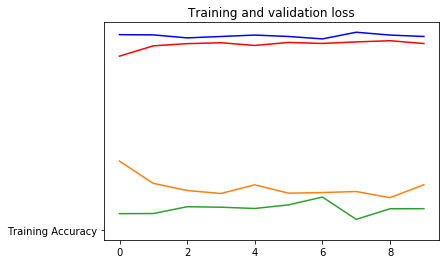

In [13]:
if __name__ == '__main__':
    main()